# Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import simplefilter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score,roc_auc_score

In [2]:
def onehot(train,test):
    onehot = OneHotEncoder().fit(train)
    train_cats = onehot.transform(train)
    test_cats = onehot.transform(test)
    train_cats = pd.DataFrame(train_cats.toarray(),columns = onehot.categories_)
    test_cats = pd.DataFrame(test_cats.toarray(), columns = onehot.categories_)
    return train_cats, test_cats

In [3]:
# Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Get Data

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
# First 5 rows of the training set
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Explore Data

In [5]:
# Descriptive Statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Data types, counts
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<b>-Cabin</b> attribute will be dropped -> it has 891-204 null values. Missing values for <b>Age</b> will be replaced with something (will decide later). <b>Name</b> and <b>Ticket</b> will be also dropped.


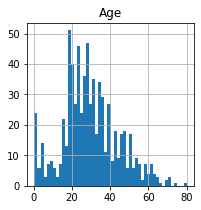

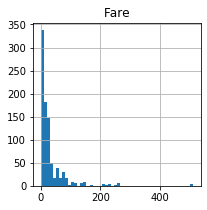

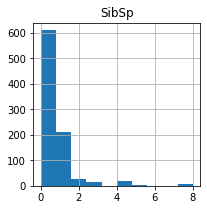

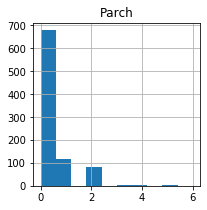

In [7]:
plt.title("Age")
train["Age"].hist(bins=50, figsize=(3,3))
plt.show()
plt.title("Fare")
train["Fare"].hist(bins=50, figsize=(3,3))
plt.show()
plt.title("SibSp")
train["SibSp"].hist(bins=10, figsize=(3,3))
plt.show()
plt.title("Parch")
train["Parch"].hist(bins=10, figsize=(3,3))
plt.show()

In [8]:
female = train.loc[train.Sex == "female"]["Survived"]
female_perc = sum(female)/len(female)
male = train.loc[train.Sex == "male"]["Survived"]
male_perc = sum(male)/len(male)
print("Total survived out of 891:",train["Survived"].value_counts()[1])
print("% of female who survived:", round(female_perc,2))
print("% of male who survived:", round(male_perc,2))


Total survived out of 891: 342
% of female who survived: 0.74
% of male who survived: 0.19


In [9]:
class1 = train.loc[train.Pclass == 1]["Survived"]
class1_perc = sum(class1)/len(class1)
class2 = train.loc[train.Pclass == 2]["Survived"]
class2_perc = sum(class2)/len(class2)
class3 = train.loc[train.Pclass == 3]["Survived"]
class3_perc = sum(class3)/len(class3)
print("% of class 1 passenger who survived:", round(class1_perc,2))
print("% of class 2 passenger who survived:", round(class2_perc,2))
print("% of class 3 passenger who survived:", round(class3_perc,2))

% of class 1 passenger who survived: 0.63
% of class 2 passenger who survived: 0.47
% of class 3 passenger who survived: 0.24


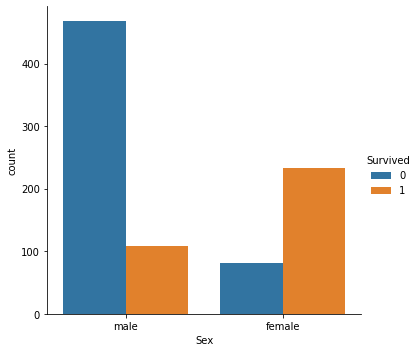

In [10]:
sns.catplot(x = "Sex", hue = "Survived", data = train, kind = "count")

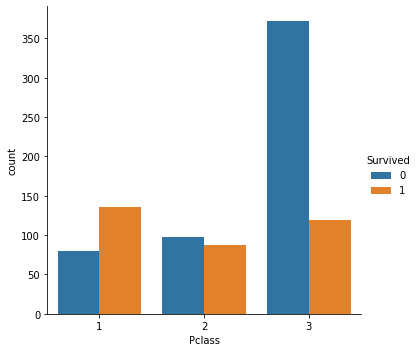

In [11]:
sns.catplot(x = "Pclass", hue = "Survived", data = train, kind = "count")

## Prepare the Data for Machine Learning Algorithms

In [12]:
train_x = train.drop(["Cabin", "Name", "Ticket","Survived","PassengerId"], axis = 1)
test_x = test.drop(["Cabin", "Name", "Ticket","PassengerId"], axis = 1)
train_y = train["Survived"]

##### Numerical Data

In [13]:
train_x_numeric = train[["Age","Fare","SibSp","Parch"]]
test_x_numeric = test[["Age","Fare","SibSp","Parch"]]

# Handling Missing Values
imputer = SimpleImputer(strategy="median").fit(train_x_numeric)
train_x_nums= imputer.transform(train_x_numeric)
test_x_nums = imputer.transform(test_x_numeric)

# Scaling
scaler = StandardScaler().fit(train_x_nums)
train_x_nums = scaler.transform(train_x_nums)
test_x_nums = scaler.transform(test_x_nums)
train_x_nums = pd.DataFrame(train_x_nums, columns = train_x_numeric.columns)
test_x_nums = pd.DataFrame(test_x_nums, columns = test_x_numeric.columns)
del train_x_numeric, test_x_numeric

##### Categorical Data

In [14]:
# Embarked has 2 NaN values they will be filled with most accured values
print(train["Embarked"].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [15]:
train["Embarked"] = train["Embarked"].fillna("S")
# Check it again
print(train["Embarked"].value_counts())

S    646
C    168
Q     77
Name: Embarked, dtype: int64


In [16]:
train_x_pclass = train[["Pclass"]].astype(object)
train_x_sex = train[["Sex"]]
train_x_embarked = train[["Embarked"]]
test_x_pclass = test[["Pclass"]].astype(object)
test_x_sex = test[["Sex"]]
test_x_embarked = test[["Embarked"]]
# Encoding
train_pclass, test_pclass = onehot(train_x_pclass, test_x_pclass)
train_pclass = train_pclass.rename(columns={1: 'Pclass_1', 2: 'Pclass_2', 3: 'Pclass_3'})
test_pclass = test_pclass.rename(columns={1: 'Pclass_1', 2: 'Pclass_2', 3: 'Pclass_3'})
train_sex, test_sex = onehot(train_x_sex, test_x_sex)
train_embarked, test_embarked = onehot(train_x_embarked, test_x_embarked)

# Merging numerics and categorical data
train_x = pd.concat([train_x_nums, train_pclass,train_sex, train_embarked],axis=1,sort=False)
test_x = pd.concat([test_x_nums,test_pclass,test_sex, test_embarked],axis=1,sort=False)

del train_x_nums, test_x_nums
del train_x_pclass, train_x_sex, train_x_embarked, test_x_pclass, test_x_sex, test_x_embarked
del train_pclass, test_pclass, train_sex, test_sex, train_embarked, test_embarked

##  Machine Learning Algorithms

## SGD

In [17]:
# Training
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(train_x, train_y)

# Evaluation with CV
sgd_scores = cross_val_score(sgd_clf,train_x, train_y, cv = 3, scoring = "accuracy")
sgd_scores = sgd_scores.mean()
sgd_scores

0.7643097643097643

In [18]:
# Grid Search
param_grid = [{"loss": ["hinge","log","modified_huber"], "penalty": ["l2","l1","elasticnet"]}]

grid_search = GridSearchCV(sgd_clf, param_grid, cv = 3,
                           scoring = "accuracy", return_train_score = True)
grid_search.fit(train_x, train_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'loss': ['hinge', 'log', 'modified_huber'],
                          'penalty': ['l2', 'l1', 'elasticnet']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_s

In [19]:
grid_search.best_params_

{'loss': 'log', 'penalty': 'elasticnet'}

In [20]:
final_sgd = grid_search.best_estimator_
final_sgd_scores = cross_val_score(final_sgd,train_x, train_y, cv = 3, scoring = "accuracy")
final_sgd_scores = final_sgd_scores.mean()
final_sgd_scores

0.7968574635241302

In [21]:
final_sgd_preds = final_sgd.predict(test_x)

## SVM

In [22]:
svm_clf = SVC()
svm_clf.fit(train_x, train_y)

# Evaluation with CV
svm_scores = cross_val_score(svm_clf,train_x, train_y, cv = 3, scoring = "accuracy")
svm_scores = svm_scores.mean()
svm_scores

0.8249158249158249

In [23]:
# # Grid Search
# param_grid = [{"kernel": ["linear","rbf", "sigmoid"],"C": [10, 100, 1000]}]
# grid_search = GridSearchCV(svm_clf, param_grid, cv = 3, scoring = "accuracy", return_train_score= True)
# grid_search.fit(train_x, train_y)
# grid_search.best_estimator_

In [24]:
# final_svm = grid_search.best_estimator_
# final_svm_scores = cross_val_score(final_svm,train_x, train_y, cv = 3, scoring = "accuracy")
# final_svm_scores = final_svm_scores.mean()
# final_svm_scores

In [25]:
# final_svm_preds = final_svm.predict(test_x)
svm_preds = svm_clf.predict(test_x)

## Logistic Regression

In [26]:
logi = LogisticRegression()
logi.fit(train_x, train_y)

# Evaluation with CV
logi_scores = cross_val_score(logi,train_x, train_y, cv = 3, scoring = "accuracy")
logi_scores = logi_scores.mean()
logi_scores

0.7912457912457912

In [27]:
# Grid Search
param_grid = [{"C": [0.5, 1, 3, 5, 10, 100, 1000], "penalty": ["l2","l1"]}]

grid_search = GridSearchCV(logi, param_grid, cv = 3,
                           scoring = "accuracy", return_train_score = True)
grid_search.fit(train_x, train_y)
grid_search.best_params_

{'C': 5, 'penalty': 'l1'}

In [28]:
final_logi = grid_search.best_estimator_
final_logi_scores = cross_val_score(final_logi,train_x, train_y, cv = 3, scoring = "accuracy")
final_logi_scores = final_logi_scores.mean()
final_logi_scores

0.7934904601571269

In [29]:
final_logi_preds = final_logi.predict(test_x)

## Decision Tree

In [30]:
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(train_x, train_y)

# Evaluation with CV
tree_scores = cross_val_score(tree_clf,train_x, train_y, cv = 3, scoring = "accuracy")
tree_scores = tree_scores.mean()
tree_scores

0.7687991021324355

In [31]:
# Grid Search
param_grid = [{"criterion": ["gini", "entropy" ] , "splitter": ["best","random"], "max_depth" : [1,3,5,7,9]}]

grid_search = GridSearchCV(tree_clf, param_grid, cv = 3,
                           scoring = "accuracy", return_train_score = True)
grid_search.fit(train_x, train_y)
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 7, 'splitter': 'random'}

In [32]:
final_tree = grid_search.best_estimator_
final_tree_scores = cross_val_score(final_tree,train_x, train_y, cv = 3, scoring = "accuracy")
final_tree_scores = final_tree_scores.mean()
final_tree_scores

0.8136924803591471

In [33]:
final_tree_preds = final_tree.predict(test_x)

## Random Forest

In [34]:
forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(train_x, train_y)

# Evaluation with CV
forest_scores = cross_val_score(forest_clf, train_x, train_y, cv = 3, scoring = "accuracy")
forest_scores = forest_scores.mean()
forest_scores

0.787878787878788

In [35]:
# Grid Search
param_grid = [{"n_estimators": [10, 20, 30, 40, 50], "criterion" : ["gini", "entropy"], "max_features": [2, 3, 4, 5, 6, 7]}]

grid_search = GridSearchCV(forest_clf, param_grid, cv = 3,
                           scoring = "accuracy", return_train_score = True)
grid_search.fit(train_x, train_y)
grid_search.best_params_

{'criterion': 'entropy', 'max_features': 4, 'n_estimators': 30}

In [36]:
final_forest = grid_search.best_estimator_
final_forest_scores = cross_val_score(final_forest,train_x, train_y, cv = 3, scoring = "accuracy")
final_forest_scores = final_forest_scores.mean()
final_forest_scores

0.8103254769921436

In [37]:
final_forest_preds = final_forest.predict(test_x)

## KNN

In [38]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(train_x, train_y)

# Evaluation with CV
knn_scores = cross_val_score(knn_clf, train_x, train_y, cv = 3, scoring = "accuracy")
knn_scores = knn_scores.mean()
knn_scores

0.7890011223344556

In [39]:
# Grid Search
param_grid = [{"n_neighbors": [1, 2, 3, 4, 5], "weights" : ["uniform", "distance"],
               "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"],"p" : [1, 2]}]

grid_search = GridSearchCV(knn_clf, param_grid, cv = 3,
                           scoring = "accuracy", return_train_score = True)
grid_search.fit(train_x, train_y)
grid_search.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}

In [40]:
final_knn = grid_search.best_estimator_
final_knn_scores = cross_val_score(final_knn, train_x, train_y, cv = 3, scoring = "accuracy")
final_knn_scores = final_knn_scores.mean()
final_knn_scores

0.8047138047138048

In [41]:
final_knn_preds = final_knn.predict(test_x)

## Naive Bayes

In [42]:
nb_clf = GaussianNB()
nb_clf.fit(train_x, train_y)

# Evaluation with CV
nb_scores = cross_val_score(nb_clf, train_x, train_y, cv = 3, scoring = "accuracy")
nb_scores = nb_scores.mean()
nb_scores

0.7665544332211

In [43]:
final_nb_preds = nb_clf.predict(test_x)

In [44]:
submission_svm_gridsearch = pd.DataFrame({"PassengerId":test["PassengerId"], "Survived": svm_preds})

In [45]:
submission_svm_gridsearch.to_csv('submission_svm.csv',index = False)